In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import matplotlib.dates as mdates


In [23]:

# Load the dataset
df = pd.read_csv('dataset_mood_smartphone.csv')


In [24]:
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nColumn information:")
df.info()
print("\nMissing values per column:")
print(df.isnull().sum())
print("\nSummary statistics:")
print(df.describe())
print("\nUnique IDs:", df['id'].nunique())
print("Unique variables:", df['variable'].nunique())
print("List of variables:", df['variable'].unique())

# 2. Convert time and add date features
df['time'] = pd.to_datetime(df['time'])
df['date'] = df['time'].dt.date
df['hour'] = df['time'].dt.hour
df['day_of_week'] = df['time'].dt.dayofweek

# 3. Analyze data completeness
print("\nTime range of the dataset:")
print(f"Start date: {df['time'].min()}")
print(f"End date: {df['time'].max()}")
print(f"Total days: {(df['time'].max() - df['time'].min()).days}")

# Count records per variable
variable_counts = df['variable'].value_counts()
print("\nRecords per variable:")
print(variable_counts)

# 4. Check value ranges for each variable
print("\nValue ranges per variable:")
for var in df['variable'].unique():
    subset = df[df['variable'] == var]
    print(f"{var}: min={subset['value'].min()}, max={subset['value'].max()}, mean={subset['value'].mean():.4f}")


Dataset shape: (376912, 5)

First 5 rows:
   Unnamed: 0       id                     time variable  value
0           1  AS14.01  2014-02-26 13:00:00.000     mood    6.0
1           2  AS14.01  2014-02-26 15:00:00.000     mood    6.0
2           3  AS14.01  2014-02-26 18:00:00.000     mood    6.0
3           4  AS14.01  2014-02-26 21:00:00.000     mood    7.0
4           5  AS14.01  2014-02-27 09:00:00.000     mood    6.0

Column information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376912 entries, 0 to 376911
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  376912 non-null  int64  
 1   id          376912 non-null  object 
 2   time        376912 non-null  object 
 3   variable    376912 non-null  object 
 4   value       376710 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 14.4+ MB

Missing values per column:
Unnamed: 0      0
id              0
time            0
vari

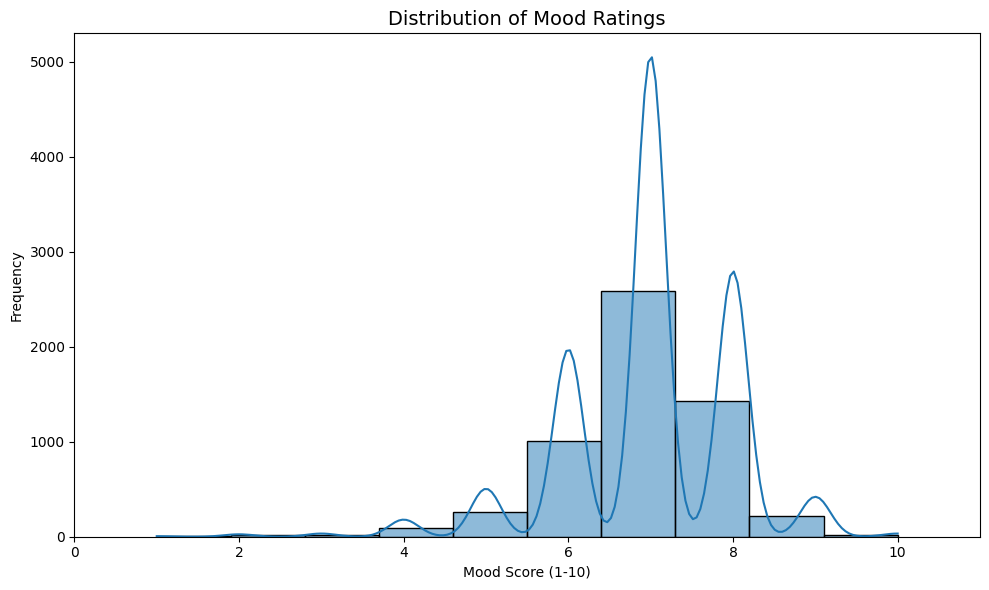

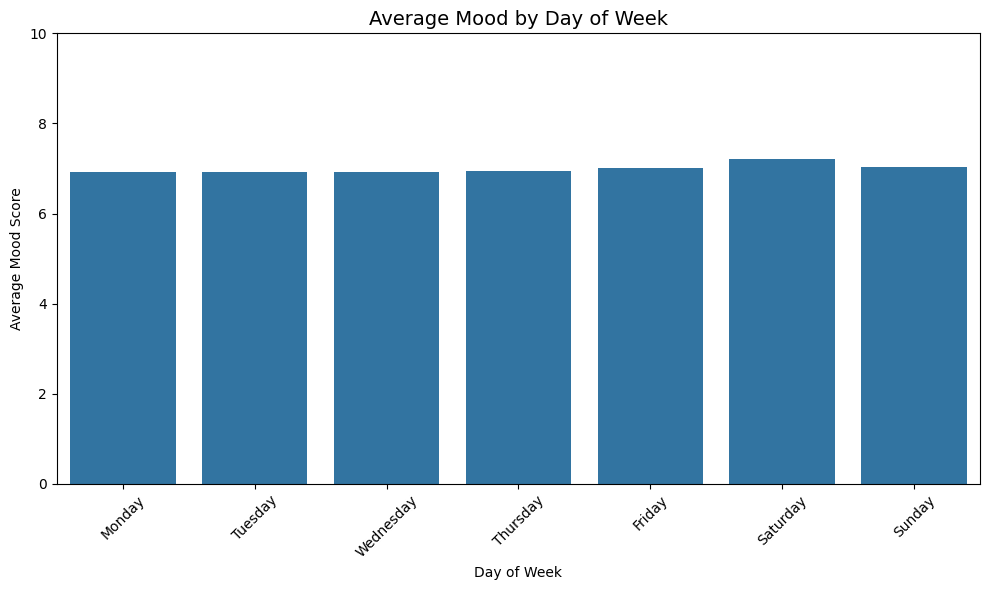

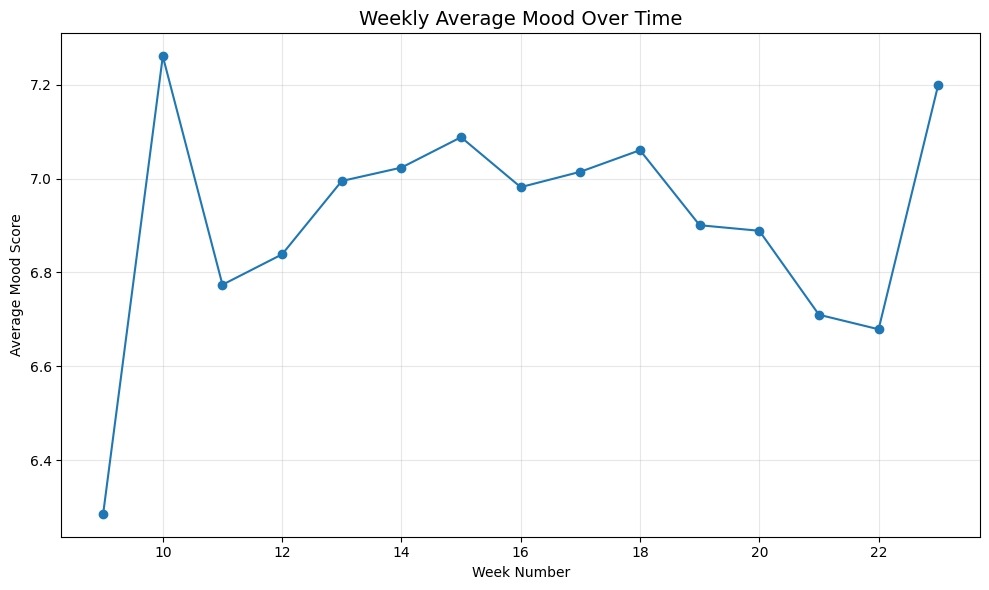

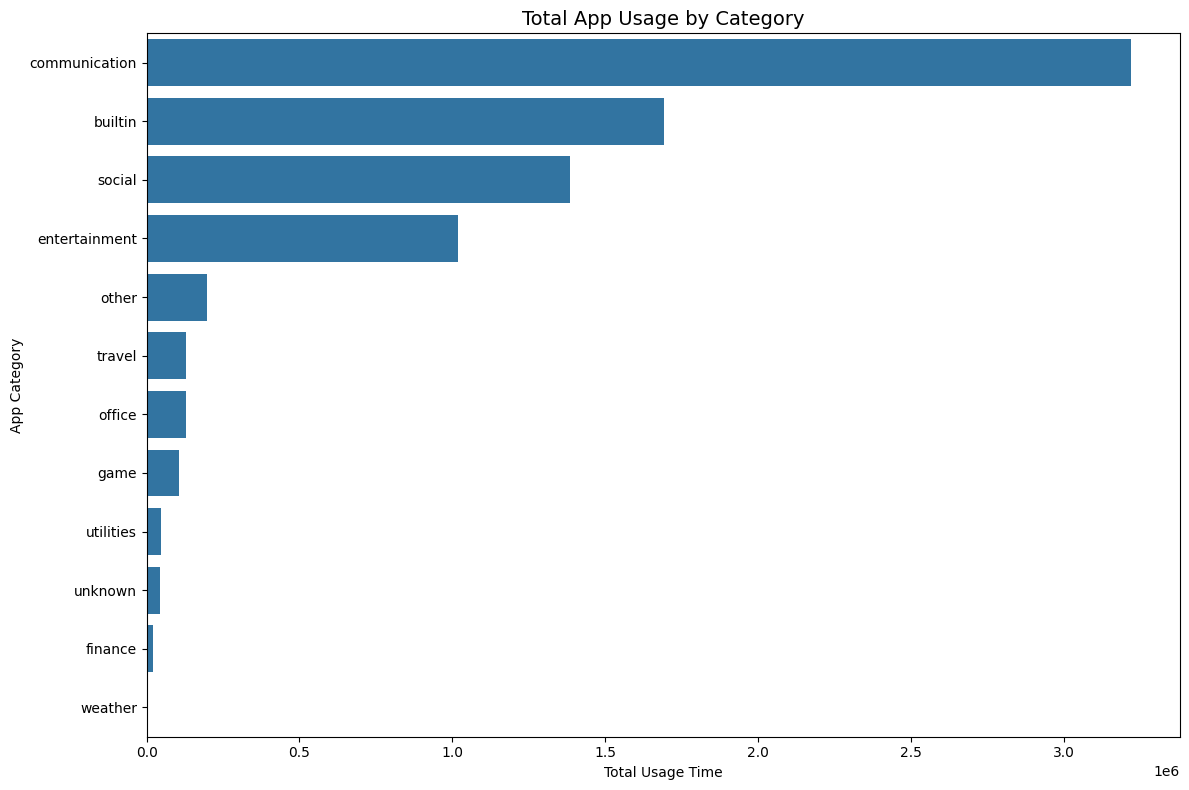

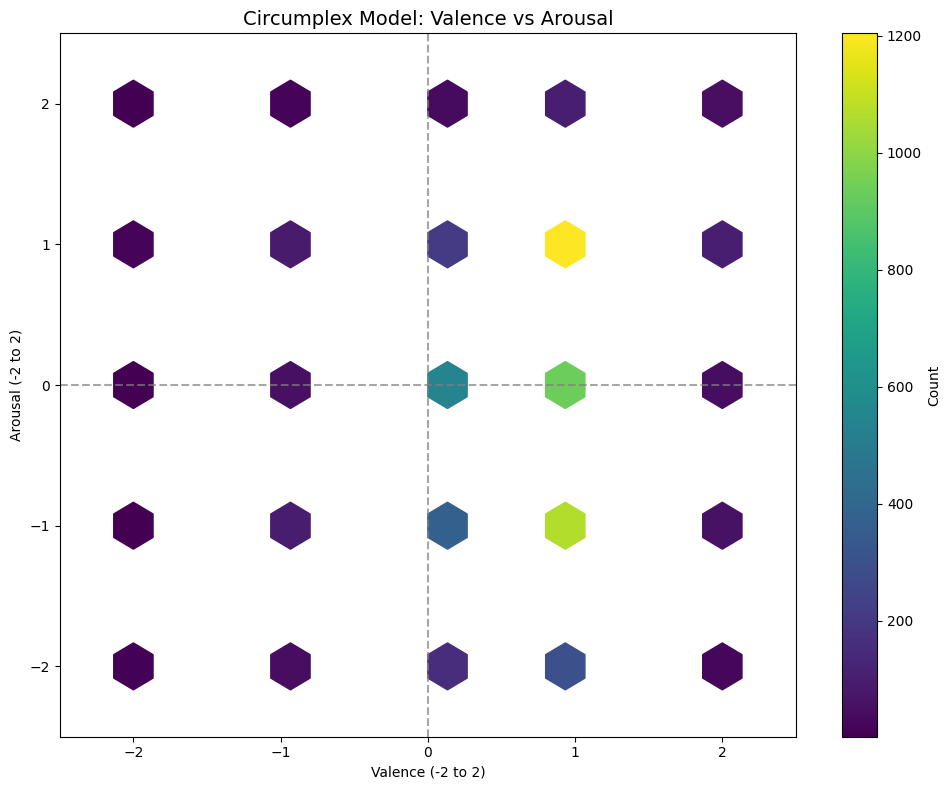

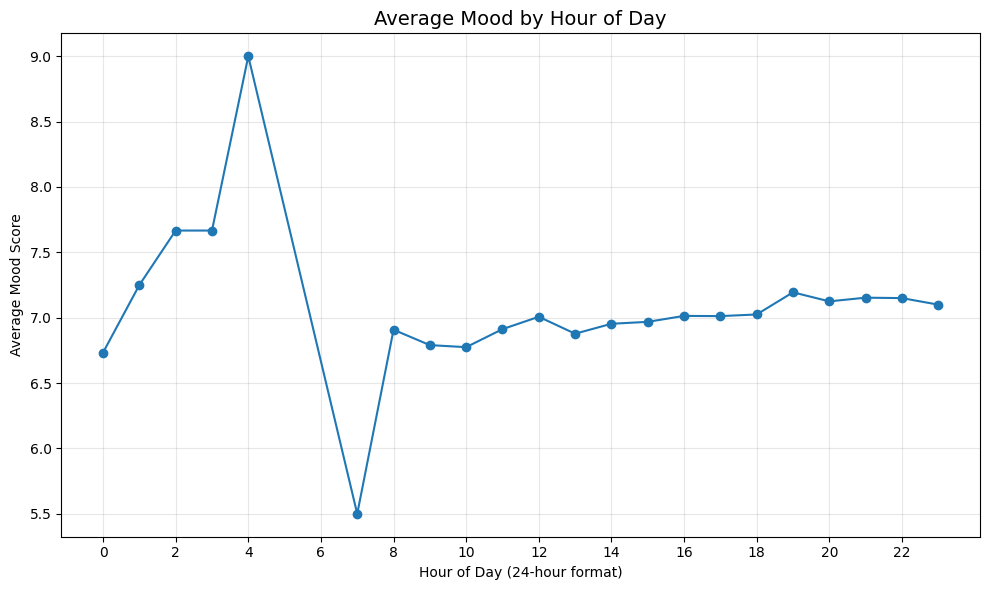

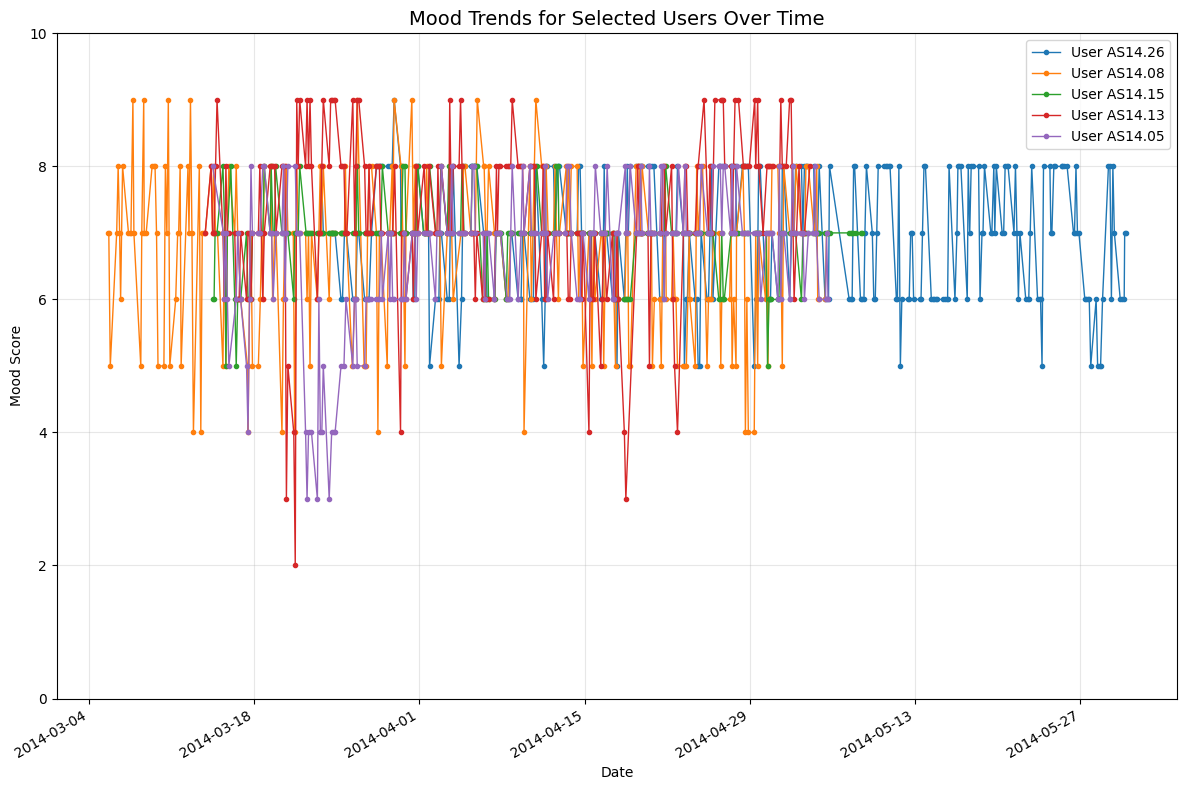

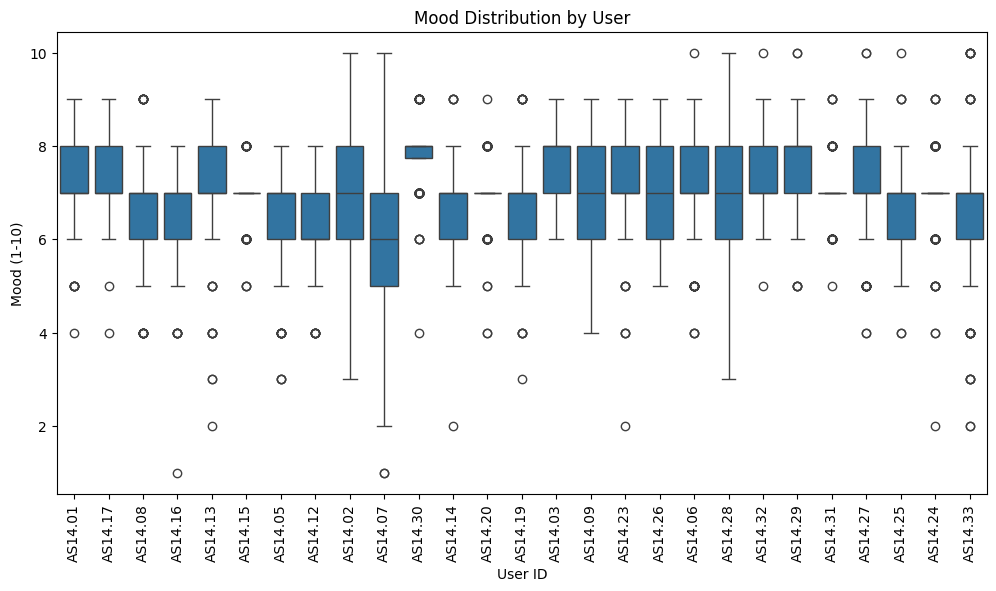

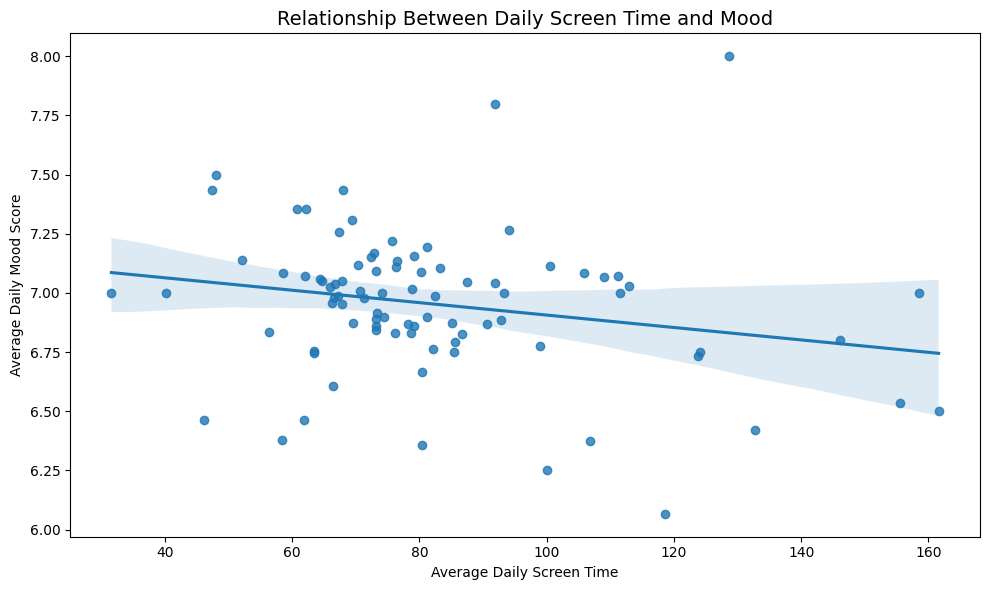

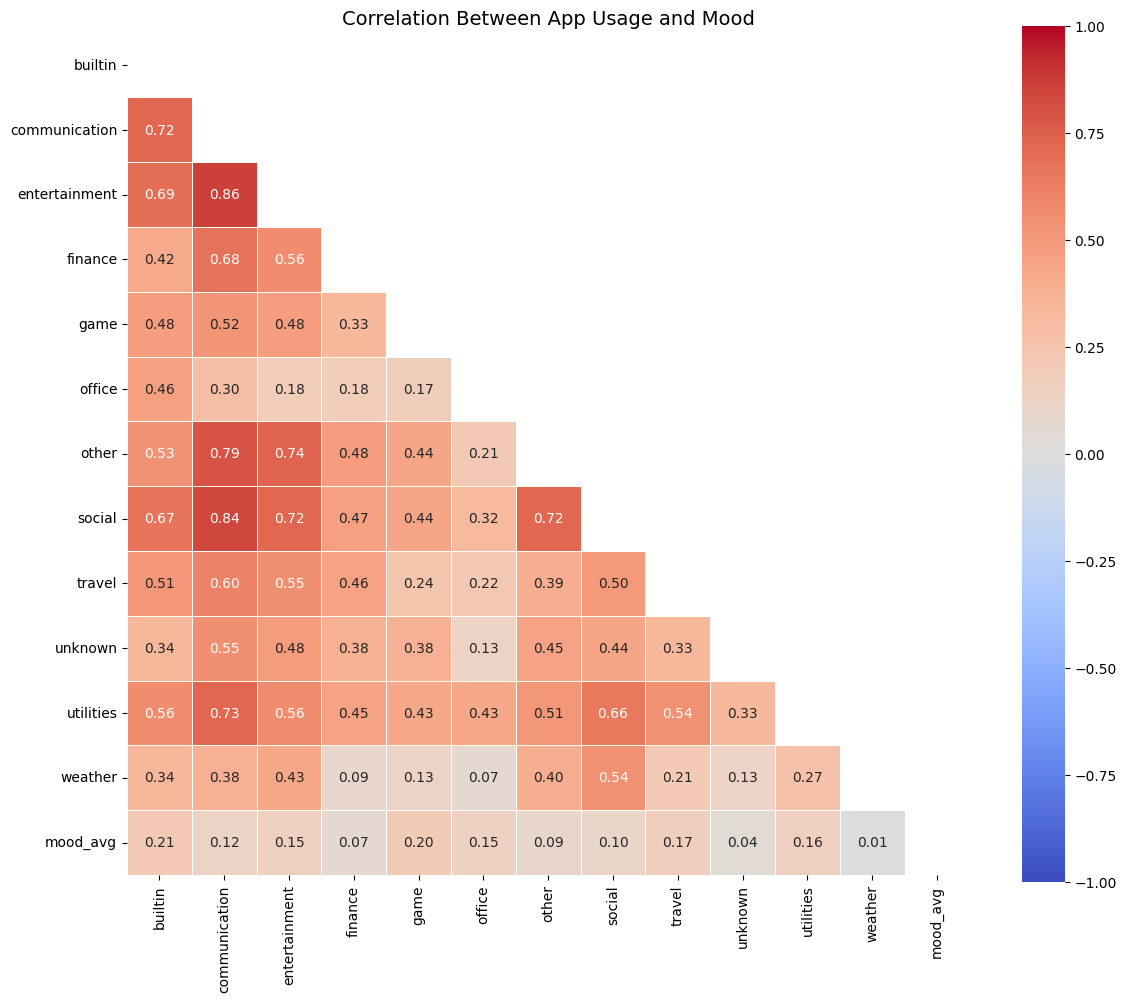

All visualizations have been created successfully!


In [25]:
# Convert time to datetime format
df['time'] = pd.to_datetime(df['time'])
# Extract date as a separate component (as datetime object for proper handling)
df['date'] = df['time'].dt.date

# 1. Mood Distribution
plt.figure(figsize=(10, 6))
mood_data = df[df['variable'] == 'mood'].copy()
sns.histplot(data=mood_data, x='value', bins=10, kde=True)
plt.title('Distribution of Mood Ratings', fontsize=14)
plt.xlabel('Mood Score (1-10)')
plt.ylabel('Frequency')
plt.xlim(0, 11)
plt.tight_layout()
# plt.savefig('mood_distribution.png', dpi=300)
plt.show()

# 2. Average Mood by Day of Week
plt.figure(figsize=(10, 6))
mood_data['day_of_week'] = mood_data['time'].dt.day_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
avg_mood_by_day = mood_data.groupby('day_of_week')['value'].mean().reindex(day_order)
sns.barplot(x=avg_mood_by_day.index, y=avg_mood_by_day.values)
plt.title('Average Mood by Day of Week', fontsize=14)
plt.xlabel('Day of Week')
plt.ylabel('Average Mood Score')
plt.xticks(rotation=45)
plt.ylim(0, 10)
plt.tight_layout()
# plt.savefig('mood_by_day.png', dpi=300)
plt.show()

# 3. Mood Trend Over Time (Weekly Average)
plt.figure(figsize=(10, 6))
# Add week number for aggregation
try:
    # For pandas >= 1.1.0
    mood_data['week'] = mood_data['time'].dt.isocalendar().week
except AttributeError:
    # For older pandas versions
    mood_data['week'] = mood_data['time'].apply(lambda x: x.isocalendar()[1])

weekly_mood = mood_data.groupby('week')['value'].mean()
plt.plot(weekly_mood.index, weekly_mood.values, marker='o', linestyle='-')
plt.title('Weekly Average Mood Over Time', fontsize=14)
plt.xlabel('Week Number')
plt.ylabel('Average Mood Score')
plt.grid(True, alpha=0.3)
plt.tight_layout()
# plt.savefig('weekly_mood_trend.png', dpi=300)
plt.show()

# 4. App Usage Distribution
plt.figure(figsize=(12, 8))
app_categories = [col for col in df['variable'].unique() if 'appCat' in col]
app_usage = []
for app in app_categories:
    app_data = df[df['variable'] == app]
    total_usage = app_data['value'].sum()
    app_usage.append({'category': app.replace('appCat.', ''), 'total_usage': total_usage})

app_usage_df = pd.DataFrame(app_usage)
app_usage_df = app_usage_df.sort_values('total_usage', ascending=False)

sns.barplot(x='total_usage', y='category', data=app_usage_df)
plt.title('Total App Usage by Category', fontsize=14)
plt.xlabel('Total Usage Time')
plt.ylabel('App Category')
plt.tight_layout()
# plt.savefig('app_usage_distribution.png', dpi=300)
plt.show()


# 5. Circumplex Model (Arousal vs Valence)
plt.figure(figsize=(10, 8))
arousal_data = df[df['variable'] == 'circumplex.arousal'].copy()
valence_data = df[df['variable'] == 'circumplex.valence'].copy()

# Create DataFrames with user, time and value for merging
arousal_df = arousal_data[['id', 'time', 'value']].rename(columns={'value': 'arousal'})
valence_df = valence_data[['id', 'time', 'value']].rename(columns={'value': 'valence'})

# Merge on user and time
circumplex_df = pd.merge(arousal_df, valence_df, on=['id', 'time'])

# Create the hexbin plot
plt.hexbin(circumplex_df['valence'], circumplex_df['arousal'], 
           gridsize=15, cmap='viridis', mincnt=1)
plt.colorbar(label='Count')
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.7)
plt.title('Circumplex Model: Valence vs Arousal', fontsize=14)
plt.xlabel('Valence (-2 to 2)')
plt.ylabel('Arousal (-2 to 2)')
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.tight_layout()
# plt.savefig('circumplex_model.png', dpi=300)
plt.show()

# 6. Hourly Mood Patterns
plt.figure(figsize=(10, 6))
mood_data['hour'] = mood_data['time'].dt.hour
hourly_mood = mood_data.groupby('hour')['value'].mean()
plt.plot(hourly_mood.index, hourly_mood.values, marker='o', linestyle='-')
plt.title('Average Mood by Hour of Day', fontsize=14)
plt.xlabel('Hour of Day (24-hour format)')
plt.ylabel('Average Mood Score')
plt.xticks(range(0, 24, 2))
plt.grid(True, alpha=0.3)
plt.tight_layout()
# plt.savefig('hourly_mood_patterns.png', dpi=300)
plt.show()

# 7. Time Series Analysis - Mood for Top Users
plt.figure(figsize=(12, 8))
top_users = mood_data['id'].value_counts().head(5).index
mood_data = mood_data.sort_values('time')

# Plot each user's mood over time
for user in top_users:
    user_data = mood_data[mood_data['id'] == user]
    plt.plot(user_data['time'], user_data['value'], marker='o', markersize=3, 
             linestyle='-', linewidth=1, label=f'User {user}')

plt.title('Mood Trends for Selected Users Over Time', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Mood Score')
plt.ylim(0, 10)
plt.legend()
plt.grid(True, alpha=0.3)
# Format date axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
plt.gcf().autofmt_xdate()
plt.tight_layout()
# plt.savefig('user_mood_trends.png', dpi=300)
plt.show()

# 8. Activity vs. Mood (Using numeric dates and calculating daily averages safely)
plt.figure(figsize=(10, 6))

# Create date string column for grouping
df['date_str'] = df['time'].dt.strftime('%Y-%m-%d')

# Get daily activity averages
activity_daily = df[df['variable'] == 'activity'].groupby('date_str')['value'].mean().reset_index()
activity_daily.columns = ['date_str', 'activity_avg']





# Get daily mood averages
mood_data['date_str'] = mood_data['time'].dt.strftime('%Y-%m-%d')  # Fix: Add date_str to mood_data

# Get daily mood averages
mood_daily = mood_data.groupby('date_str')['value'].mean().reset_index()
mood_daily.columns = ['date_str', 'mood_avg']

# Join them together
daily_data = pd.merge(activity_daily, mood_daily, on='date_str', how='inner')

# Create scatter plot with regression line
sns.regplot(x='activity_avg', y='mood_avg', data=daily_data)
plt.title('Relationship Between Daily Activity and Mood', fontsize=14)
plt.xlabel('Average Daily Activity Level')
plt.ylabel('Average Daily Mood Score')
plt.tight_layout()
plt.savefig('activity_mood_correlation.png', dpi=300)
plt.close()

plt.figure(figsize=(12, 6))
sns.boxplot(data=mood_data, x='id', y='value')
plt.title('Mood Distribution by User')
plt.xlabel('User ID')
plt.ylabel('Mood (1-10)')
plt.xticks(rotation=90)
# plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


# 9. Screen Time vs. Mood (Using numeric dates)
plt.figure(figsize=(10, 6))

# Get daily screen time averages
screen_daily = df[df['variable'] == 'screen'].groupby('date_str')['value'].mean().reset_index()
screen_daily.columns = ['date_str', 'screen_avg']

# Join with daily mood data
screen_mood = pd.merge(screen_daily, mood_daily, on='date_str', how='inner')

# Create scatter plot with regression line
sns.regplot(x='screen_avg', y='mood_avg', data=screen_mood)
plt.title('Relationship Between Daily Screen Time and Mood', fontsize=14)
plt.xlabel('Average Daily Screen Time')
plt.ylabel('Average Daily Mood Score')
plt.tight_layout()
# plt.savefig('screen_mood_correlation.png', dpi=300)
plt.show()

# 10. App Usage and Mood Correlation Heatmap
# Calculate daily app usage for each category
plt.figure(figsize=(12, 10))

# Prepare data: Get daily usage for each app category
app_categories = [col for col in df['variable'].unique() if 'appCat' in col]
app_daily_usage = pd.DataFrame({'date_str': mood_daily['date_str'].unique()})

# For each app category, calculate daily usage
for app in app_categories:
    app_name = app.replace('appCat.', '')
    app_data = df[df['variable'] == app]
    if not app_data.empty:
        daily_usage = app_data.groupby('date_str')['value'].sum().reset_index()
        daily_usage.columns = ['date_str', app_name]
        app_daily_usage = pd.merge(app_daily_usage, daily_usage, on='date_str', how='left')

# Add mood data
app_daily_usage = pd.merge(app_daily_usage, mood_daily, on='date_str', how='left')
app_daily_usage = app_daily_usage.fillna(0)  # Replace NaN with 0 (no usage)

# Calculate correlation and create heatmap
# First, remove the date column which is not numeric
correlation_data = app_daily_usage.drop(columns=['date_str'])
correlation_matrix = correlation_data.corr()

# Create mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Draw heatmap
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
            vmin=-1, vmax=1, center=0, square=True, linewidths=.5)
plt.title('Correlation Between App Usage and Mood', fontsize=14)
plt.tight_layout()
# plt.savefig('app_mood_correlation.png', dpi=300)
plt.show()

print("All visualizations have been created successfully!")